# 03 - Auto Insurance Claim Processing Workflow

- **Parse the Claim Document**: Extract key fields (claim number, date of loss, claimant name, policy number, loss description, estimated damage costs).
- **Index/Load Insurance Policy Documents**: Use Langchain to index the insurance policy documents and make them retrievable for querying.
- **Generate Relevant Queries**: Based on the extracted claim details, construct vector-based queries using Langchain's query generation capabilities to retrieve relevant coverage sections from the indexed policy documents.
- **Match Conditions Against Policy**: Use Langchain with LLMs (Large Language Models) to reason whether the claim is covered, determine applicable deductibles, identify any special endorsements, and suggest the recommended settlement amount.
- **Produce a Structured Output**: Summarize the final recommended settlement and conditions for payment in a clear, structured format for further processing.

In [1]:
import os
from dotenv import load_dotenv

# Step 1: Load environment variables from .env file
load_dotenv()

# Step 2: Retrieve Azure OpenAI environment variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")

from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",  # Your Azure deployment
    api_version=OPENAI_API_VERSION,  # Your API version
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

embeddings = AzureOpenAIEmbeddings(
    api_version=OPENAI_API_VERSION,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
)


## Retriever 
A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them. Vector stores can be used as the backbone of a retriever, but there are other types of retrievers as well.

### Loading the Claim Document
In a real scenario, we’d have a PDF or text form with claim details. For this demonstration, we assume we have a JSON file containing claim data.

In [2]:
# Uncomment the following line if you need to initialize FAISS with no AVX2 optimization
# os.environ['FAISS_NO_AVX2'] = '1'

from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS

# Initialize an empty list to hold all documents
all_documents = []

# List of file paths
file_paths = ["data/john-declarations.md", "data/alice-declarations.md"]

# Loop through each file path
for file_path in file_paths:
    loader = TextLoader(file_path=file_path)
    documents = loader.load()
    all_documents.extend(documents)  # Append the documents to the list

# After loop, create the vector store from all documents
vector_store = FAISS.from_documents(all_documents, embeddings)

In [3]:
def get_declarations_docs(policy_number: str, top_k: int = 1):
    """Retrieve declarations pages for a given policy number."""
    # Create the retriever with the metadata filter
    retriever = vector_store.as_retriever(search_kwargs={"k": top_k})
    # Perform the retrieval
    docs = retriever.invoke(f"declarations page for {policy_number}")
    return docs

In [4]:
# try it out 
docs = get_declarations_docs("POLICY-ABC123")
print(len(docs))

1


In [5]:
print(docs[0].page_content)

# CALIFORNIA PERSONAL AUTO POLICY DECLARATIONS PAGE
**Policy Number:** CAP-ABC123-01  
**Policy Period:** 01/01/2024 to 07/01/2024  
(12:01 A.M. standard time at the address below)

**Named Insured:**  
John Smith  
456 Delivery Lane  
San Francisco, CA 94112

**Vehicle Information:**  
Vehicle: 2022 Honda Civic LX Sedan  
VIN: 2HGFE2F54NH123456  
Principal Operator: John Smith  
Usage: Personal

**Coverages and Premiums:**

- Bodily Injury Liability: $100,000/$300,000 [$450]
- Property Damage Liability: $50,000 [$295]
- Medical Payments: $5,000 [$80]
- Uninsured/Underinsured Motorist: $100,000/$300,000 [$115]
- Collision Coverage: $500 deductible [$425]
- Other Than Collision: $250 deductible [$210]
- Rental Reimbursement: $30/day, max $900 [$30]
- Towing and Labor: $75 per disablement [$20]

**Total Semi-Annual Premium:** $1,625

**Discounts Applied:**
- Safe Driver Discount
- Anti-theft Device Discount
- Automatic Payment Discount

**Forms and Endorsements:**
- CAIP400 (03012006) - 

## Prompts
### Generating Policy Queries
We prompt the LLM to generate queries for retrieving relevant policy sections. For example:

- Coverage conditions for collision damage.
- Deductible conditions.
- Any special endorsements for rental coverage or waived deductible scenarios.

In [6]:
GENERATE_POLICY_QUERIES_PROMPT = """
You are an assistant tasked with determining what insurance policy sections to consult for a given auto claim.

**Instructions:**
1. Review the claim data, including the type of loss (rear-end collision), estimated repair cost, and policy number.
2. Identify what aspects of the policy we need:
   - Collision coverage conditions
   - Deductible application
   - Any special endorsements related to rear-end collisions or no-fault scenarios
3. Produce 3-5 queries that can be used against a vector index of insurance policies to find relevant clauses.

Claim Data:
{claim_info}

Return a JSON object matching the PolicyQueries schema.
{format_instructions}
"""

### Policy Recommendation Prompt
Once we have queries, we’ll run them against the policy index, retrieve the text, and feed it back to the LLM to produce a PolicyRecommendation.

In [7]:
POLICY_RECOMMENDATION_PROMPT = """
Given the retrieved policy sections for this claim, determine:
- If the collision is covered
- The applicable deductible
- Recommended settlement amount (e.g., cost minus deductible)
- Which policy section applies

Claim Info:
{claim_info}

Policy Text:
{policy_text}

Return a JSON object matching PolicyRecommendation schema.
{format_instructions}
"""

## Schema

### Define Data Schemas with Pydantic:
- Utilize Pydantic's BaseModel to define structured data models for your claim information and policy recommendations.

In [8]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ClaimInfo(BaseModel):
    """Extracted Insurance claim information."""
    claim_number: str
    policy_number: str
    claimant_name: str
    date_of_loss: str
    loss_description: str
    estimated_repair_cost: float
    vehicle_details: Optional[str] = None

class PolicyQueries(BaseModel):
    queries: List[str] = Field(
        default_factory=list,
        description="A list of query strings to retrieve relevant policy sections."
    )

class PolicyRecommendation(BaseModel):
    """Policy recommendation regarding a given claim."""
    policy_section: str = Field(..., description="The policy section or clause that applies.")
    recommendation_summary: str = Field(..., description="A concise summary of coverage determination.")
    deductible: Optional[float] = Field(None, description="The applicable deductible amount.")
    settlement_amount: Optional[float] = Field(None, description="Recommended settlement payout.")
    
class ClaimDecision(BaseModel):
    claim_number: str
    covered: bool
    deductible: float
    recommended_payout: float
    notes: Optional[str] = None

## LangGraph Components:

Set up the graph builder and define the state object to manage shared data across nodes.

In [9]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

# Define Workflow State and Events
class State(TypedDict):
    claim_info: ClaimInfo
    policy_recommendation: Optional[PolicyRecommendation] = None
    policy_text: Optional[str] = None
    final_decision : ClaimDecision

# Initialize the graph and define state structure
graph_builder = StateGraph(State)

### Define Node Functions:

Implement functions that will serve as nodes in the graph, such as parsing claim data and generating policy recommendations.

In [10]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate

def parse_claim(state: State):
    print('parse_claim')
    # Implement claim parsing logic here
    # For example, extract claim information from a document
    # claim_info = ClaimInfo(
    #     claim_number="12345",
    #     policy_number="POLICY-ABC123",
    #     claimant_name="John Doe",
    #     date_of_loss="2024-12-15",
    #     loss_description="Rear-end collision",
    #     estimated_repair_cost=5000.0,
    #     vehicle_details="2019 Honda Accord"
    # )
    # state['claim_info'] = claim_info
    return state

def generate_policy_queries(state: State):
    print('generate_policy_queries')
    # Implement policy query generation logic here
    # For example, use LLM to generate queries based on claim info
    # queries = [
    #     "Coverage conditions for collision damage.",
    #     "Deductible conditions.",
    #     "Any special endorsements for rental coverage or waived deductible scenarios."
    # ]

    # Output parser for the response
    output_parser = JsonOutputParser(pydantic_object=PolicyQueries)
    # Create a prompt template for insurance-related query
    prompt = PromptTemplate(
        template=GENERATE_POLICY_QUERIES_PROMPT,
        input_variables=["claim_info"],
        partial_variables={"format_instructions": output_parser.get_format_instructions()},
    )
    # Chain setup with model and output parser
    chain = prompt | llm | output_parser
    # Invoke with insurance-related topic
    queries = chain.invoke({"claim_info": state['claim_info']})
    state['policy_queries'] = queries['queries'] 
    return state

def retrieve_policy_text(state: State):
    print('retrieve_policy_text')
    # Implement policy text retrieval logic here
    # For example, use LLM to fetch relevant policy sections
    policy_text = get_declarations_docs(state['claim_info']['policy_number'])
    # policy_text = "Sample policy text relevant to the claim."
    state['policy_text'] = policy_text
    return state

def generate_recommendation(state: State):
    print('generate_recommendation')
    # Implement policy recommendation generation logic here
    # For example, use LLM to analyze policy text and generate recommendations
    # Output parser for the response
    output_parser = JsonOutputParser(pydantic_object=PolicyRecommendation)
    # Create a prompt template for insurance-related query
    prompt = PromptTemplate(
        template=POLICY_RECOMMENDATION_PROMPT,
        input_variables=["claim_info", "policy_text"],
        partial_variables={"format_instructions": output_parser.get_format_instructions()},
    )
    # Chain setup with model and output parser
    chain = prompt | llm | output_parser
    # Invoke with insurance-related topic
    recommendation = chain.invoke({
        "claim_info": ['claim_info'], 
        "policy_text": state['policy_text']
    })
    recommendation = PolicyRecommendation(
        policy_section="Collision Coverage",
        recommendation_summary="Coverage applicable for rear-end collisions.",
        deductible=500.0,
        settlement_amount=4500.0
    )
    
    state['policy_recommendation'] = recommendation
    return state

def finalize_decision(state: State):
    # Implement decision finalization logic here
    # For example, determine if the claim is covered and calculate payout
    recommendation = state['policy_recommendation']
    print(recommendation)
    covered = "covered" in recommendation.recommendation_summary.lower() or (recommendation.settlement_amount is not None and recommendation.settlement_amount > 0)
    deductible = recommendation.deductible if recommendation.deductible is not None else 0.0
    recommended_payout = recommendation.settlement_amount if recommendation.settlement_amount else 0.0
    decision = {
        "claim_number": state['claim_info']['claim_number'],
        "covered": covered,
        "deductible": deductible,
        "recommended_payout": recommended_payout,
        "notes": recommendation.recommendation_summary
    }
    state['final_decision'] = decision
    return state


In [11]:
graph_builder.add_node("parse_claim", parse_claim)
graph_builder.add_node("generate_policy_queries", generate_policy_queries)
graph_builder.add_node("retrieve_policy_text", retrieve_policy_text)
graph_builder.add_node("generate_recommendation", generate_recommendation)
graph_builder.add_node("finalize_decision", finalize_decision)

### Define Workflow Edges:
Specify the flow of data between nodes using edges.

In [12]:
graph_builder.add_edge(START, "parse_claim")
graph_builder.add_edge("parse_claim", "generate_policy_queries")
graph_builder.add_edge("generate_policy_queries", "retrieve_policy_text")
graph_builder.add_edge("retrieve_policy_text", "generate_recommendation")
graph_builder.add_edge("generate_recommendation", "finalize_decision")
graph_builder.add_edge("finalize_decision", END)

### Compile and Execute the Workflow:

Compile the graph and execute it to process a sample claim.

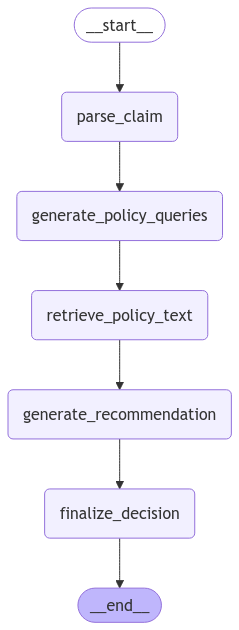

In [13]:
from IPython.display import Image, display

# Compile the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# Sample input data
sample_claim = {
    "claim_number": "12345",
    "policy_number": "POLICY-ABC123",
    "claimant_name": "John Doe",
    "date_of_loss": "2024-12-15",
    "loss_description": "Rear-end collision",
    "estimated_repair_cost": 5000.0,
    "vehicle_details": "2019 Honda Accord"
}

# Define Workflow State and Events
# class State(TypedDict):
#     claim_info: ClaimInfo
#     policy_recommendation: Optional[PolicyRecommendation] = None
#     policy_text: Optional[str] = None
#     final_decision : ClaimDecision

In [15]:
# Run the workflow
state = graph.invoke({"claim_info" : sample_claim})

parse_claim
generate_policy_queries
retrieve_policy_text
generate_recommendation
policy_section='Collision Coverage' recommendation_summary='Coverage applicable for rear-end collisions.' deductible=500.0 settlement_amount=4500.0


In [16]:
state['claim_info']

{'claim_number': '12345',
 'policy_number': 'POLICY-ABC123',
 'claimant_name': 'John Doe',
 'date_of_loss': '2024-12-15',
 'loss_description': 'Rear-end collision',
 'estimated_repair_cost': 5000.0,
 'vehicle_details': '2019 Honda Accord'}

In [17]:
state['policy_recommendation']

PolicyRecommendation(policy_section='Collision Coverage', recommendation_summary='Coverage applicable for rear-end collisions.', deductible=500.0, settlement_amount=4500.0)

In [18]:
state['final_decision']

{'claim_number': '12345',
 'covered': True,
 'deductible': 500.0,
 'recommended_payout': 4500.0,
 'notes': 'Coverage applicable for rear-end collisions.'}